In [1]:
import pandas as pd
import os
import time
import numpy as np
import pandas as pd
#from sklearnex import patch_sklearn #use intel patch before importing sklearn
#patch_sklearn()
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn import linear_model, svm, tree, ensemble, neighbors
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
import lightgbm as lgbm

/Users/albertdulout/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [15]:
#%cd ./network_sniff/
#%ls

# 0) Create reporting 

In [2]:
def model_cv_rapport(model , name  : str, x : np.array, y : np.array, cv=5, precision = 8):
    """
    Apply the model then cross validate and export its score 
    """
    #making sure data is standarized
    pipe = Pipeline([
        ('scale', preprocessing.StandardScaler()),
        ('clf', model)
    ])
    score = cross_validate(pipe, x, y, cv=cv,
                           scoring=["precision", "recall", "f1", "roc_auc", "accuracy"],
                           #verbose=10,
                           n_jobs=-1)
    print (name, "--------------------------------------")
    print("Precision: ", round(score["test_precision"].mean(), precision))
    print("Recall: ", round(score["test_recall"].mean(), precision))
    print("F1: ", round(score["test_f1"].mean(), precision))
    print("ROC: ", round(score["test_roc_auc"].mean(), precision))
    print("Accuracy: ", round(score["test_accuracy"].mean(), precision))

# 1) Import the dataset

As https://doi.org/10.1016/j.comcom.2021.02.016 and promizing : http://doi.acm.org/10.1145/3243734.3243858


In [5]:
df_mining = pd.read_csv(os.getcwd()+'/network_sniff/traffic_minage_1811_15.csv', index_col= 0)
df_not_mining = pd.read_csv(os.getcwd()+'/network_sniff/2911_traffic_calme.csv', index_col= 0)

In [6]:
df_mining.groupby('Destination').count()


,Time,Source,Protocol,Length,Info
Destination,,,,,
10.29.231.206,37,37,37,37,37
178.128.242.134,6,6,6,6,6
192.44.75.10,2,2,2,2,2
199.247.27.41,1,1,1,1,1
23.200.86.233,8,8,8,8,8
23.200.87.12,6,6,6,6,6
34.120.208.123,2,2,2,2,2
34.160.144.191,2,2,2,2,2
34.98.75.36,2,2,2,2,2


We define all traffic trom the mining dataset as comming from the miner and all the one from the other dataset as not mining
Moreover we add the direction of the package

In [10]:
df_mining['miner'] = True
df_mining['outbound'] = df_mining['Source'].apply(lambda x : x == '10.29.231.206') #change ip of miner
df_not_mining['miner'] = False
df_not_mining['outbound'] = df_not_mining['Source'].apply(lambda x : x == 'df_not_mining')

Compute time difference between two packages

In [8]:
df_mining['delta'] = df_mining.Time.diff()
df_not_mining['delta'] = df_not_mining.Time.diff()

Compute time and packet size rolling average and std

In [12]:
window = 4

In [14]:
# delta
# Rolling average
df_mining['ra_delta'] = df_mining.delta.rolling(window=window).mean()
df_not_mining['ra_delta'] = df_not_mining.delta.diff().rolling(window=window).mean()
# Standard Deviation
df_mining['rstd_delta'] = df_mining.delta.rolling(window=window).mean()
df_not_mining['rstd_delta'] = df_not_mining.delta.diff().rolling(window=window).mean()

# Lenght
# Rolling average
df_mining['ra_lenght'] = df_mining.Length.rolling(window=window).mean()
df_not_mining['ra_lenght'] = df_not_mining.Length.diff().rolling(window=window).mean()
# Standard Deviation
df_mining['rstd_lenght'] = df_mining.Length.rolling(window=window).std()
df_not_mining['rstd_lenght'] = df_not_mining.Length.diff().rolling(window=window).std()


In [21]:
df_ML = pd.concat([df_mining, df_not_mining])
df_ML.reset_index(inplace = True)
df_ML.drop(['Time', 'Source', 'No.', 'Destination', 'Protocol', 'Info'], axis = 1, inplace = True)

In [22]:
df_ML.describe()
df_ML.dropna(inplace = True)
df_ML.columns

Index(['Length', 'miner', 'delta'], dtype='object')

In [23]:
df_ML.groupby('miner').mean()

,Length,delta
miner,,
False,755.159375,0.030100
True,89.083333,0.726751


array([[<AxesSubplot:title={'center':'Length'}>,
        <AxesSubplot:title={'center':'delta'}>]], dtype=object)

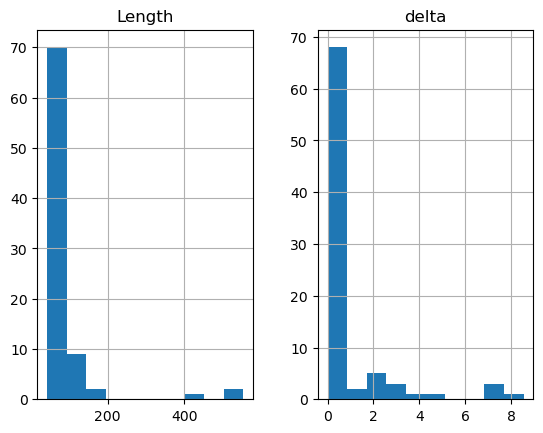

In [24]:
df_ML.loc[df_ML['miner'] == True].hist()

array([[<AxesSubplot:title={'center':'Length'}>,
        <AxesSubplot:title={'center':'delta'}>]], dtype=object)

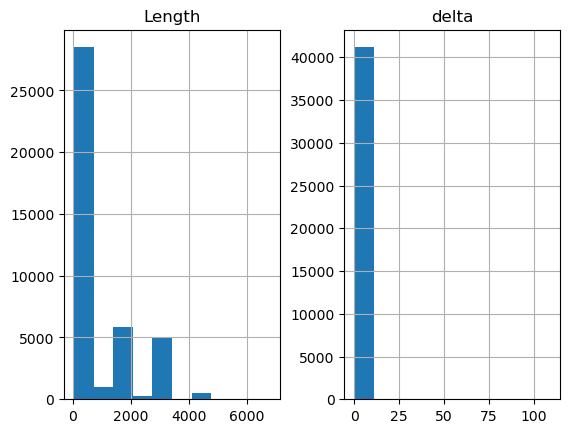

In [25]:
df_ML.loc[df_ML['miner'] == False].hist()

In [26]:
y = df_ML['miner']
x = df_ML.drop('miner', axis = 1)

In [27]:
y.describe

<bound method NDFrame.describe of 1         True
2         True
3         True
4         True
5         True
         ...  
41267    False
41268    False
41269    False
41270    False
41271    False
Name: miner, Length: 41270, dtype: bool>

In [28]:
y.value_counts()

False    41186
True        84
Name: miner, dtype: int64

# ML Algorithm

In [29]:
#Setting model
model = svm.SVC(kernel="rbf", gamma="scale", class_weight='balanced')

In [30]:
model_cv_rapport(model, "Non tuned SVC", x, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END  accuracy: (test=0.453) f1: (test=0.006) precision: (test=0.003) recall: (test=0.765) roc_auc: (test=0.683) total time= 5.5min
[CV] START .....................................................................
[CV] END  accuracy: (test=0.370) f1: (test=0.006) precision: (test=0.003) recall: (test=1.000) roc_auc: (test=0.826) total time= 6.4min


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  7.0min remaining: 10.6min


[CV] END  accuracy: (test=0.440) f1: (test=0.007) precision: (test=0.003) recall: (test=0.941) roc_auc: (test=0.842) total time= 6.5min


[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  7.1min remaining:  4.7min


[CV] END  accuracy: (test=0.514) f1: (test=0.008) precision: (test=0.004) recall: (test=0.941) roc_auc: (test=0.807) total time= 6.5min
[CV] END  accuracy: (test=0.366) f1: (test=0.006) precision: (test=0.003) recall: (test=0.938) roc_auc: (test=0.690) total time= 2.6min
Non tuned SVC --------------------------------------


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.8min finished


Precision:  0.00328183
Recall:  0.91691176
F1:  0.00653994
ROC:  0.76969121
Accuracy:  0.42842258
